In [5]:
import pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import time

from tqdm import tqdm

In [2]:
import xlrd

In [3]:
import torch
import transformers
import sklearn as skl

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.utils import class_weight

In [5]:
dataset_path = "sensitive_topics.xls"

Словарь для трансляции лейблов в метки классов

Подгрузка датасета

In [6]:
rb = xlrd.open_workbook(dataset_path)
#выбираем активный лист

sheet = rb.sheet_by_index(0)

datavals = []
datalabels = []


#формируем трансляторы
labels = sheet.row_values(0)[1:]
LabtoNum = {}
NumToLab = {}

cnt = 0
for elm in labels:
    if elm == '':
        break
    LabtoNum[elm] = cnt
    NumToLab[cnt] = elm
    cnt += 1

#выгружаем данные
for index in range(1, sheet.nrows):
    data = sheet.row_values(index)[0]
    labels = sheet.row_values(index)[1:]

    if labels[18] == '':
        datavals.append(data)
        datalabels.append(torch.tensor([float(l) if l != '' else 0.0 for l in labels[0:18]]))

In [7]:
class MyDataset:
    def __init__(self,datavals,datatags, shuffle = False):            
        self.datavals = datavals
        self.datatags = datatags
        
        if(shuffle):
            self.datavals, self.datatags = skl.utils.shuffle(self.datavals, self.datatags)
            
    def __len__(self):
        return len(self.datavals)
    
    def __getitem__(self,idx):
        return self.datavals[idx], self.datatags[idx]

In [8]:
batch_size = 4
part = 0.8

data = MyDataset(datavals, datalabels, shuffle = True)
train,valid = torch.utils.data.random_split(data,[part, 1 - part])
trainloader = torch.utils.data.DataLoader(train, batch_size = batch_size)
validloader = torch.utils.data.DataLoader(valid, batch_size = batch_size)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
# sismetanin/rubert-toxic-pikabu-2ch

# cointegrated/rubert-tiny-toxicity
# ai-forever/ruBert-base
# DeepPavlov/rubert-base-cased-conversational

In [28]:
from transformers import BertForSequenceClassification, BertTokenizer, pipeline

# загружаем предобученный классификатор
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-conversational', num_labels = len(LabtoNum.values()), problem_type="multi_label_classification")
#model = BertForSequenceClassification.from_pretrained('sismetanin/rubert-toxic-pikabu-2ch', problem_type="multi_label_classification")

tokenizer=BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-conversational', do_lower_case=False)

# ставим новую голову
# model.classifier = torch.nn.Sequential(
#     torch.nn.Linear(768, len(LabtoNum.values()))
#     #torch.nn.Tanh()
#     #torch.nn.Softmax(dim = -1)
# )

#делаем берт необучаемым
for param in model.bert.parameters():
    param.requires_grad = False 
    
#записываем трансляторы
model.config.id2label = NumToLab
model.config.label2id = LabtoNum

#делаем классификатор
classifier = pipeline("text-classification", model=model,tokenizer=tokenizer, device = device)
classifier.model.bert.eval()
print()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from sklearn.utils import class_weight

wts = torch.tensor(class_weight.compute_class_weight(class_weight = 'balanced',
                                             classes = list(LabtoNum.keys()), 
                                             y = np.array([NumToLab[idx] for elm in train for idx, val in enumerate(elm[1]) if val != 0 ])))

print(wts)

tensor([0.9778, 1.7879, 0.5015, 0.9489, 0.9541, 1.4874, 1.8819, 1.3952, 1.4804,
        0.8626, 1.5398, 1.1389, 0.8115, 1.2182, 0.4853, 0.9723, 1.1668, 0.9616],
       dtype=torch.float64)


In [15]:
criterion = torch.nn.CrossEntropyLoss(weight=wts.to(device))
#optimizer = torch.optim.Adadelta(classifier.model.parameters(), lr=0.8, weight_decay = 0)
optimizer = torch.optim.Adam(classifier.model.parameters(), lr=4e-4)


In [18]:
def test(model, testloader,criterion, verbal = True, rec_loss = False):
    #was_training = copy.deepcopy(model.model.training)
    #model.model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    if(verbal):
        iterator = tqdm(testloader)
    else:
        iterator = testloader
        
    for inputs, labels in iterator:
        inputs = inputs
        labels = labels
        
        with torch.no_grad():
            inp = model.tokenizer(inputs, return_tensors = "pt", padding=True)
            inp = inp.to(device)
            outputs = model.model(**inp)
            
        res = outputs.logits
        pred = torch.argmax(res, dim = 1)
        
        loss = criterion(res, labels.to(device))
        running_loss += loss.item()
        running_corrects += sum(pred.to("cpu") == torch.argmax(labels.to("cpu"), dim = 1))
        
    ovl_loss = running_loss / len(testloader)
    ovl_acc = float(running_corrects) / (len(testloader) * testloader.batch_size)

    if(verbal):
        print('test | loss function val: {} accuracy: {}'.format(ovl_loss, ovl_acc))
    
    #if(was_training):
    #    model.model.train()
        
    if(rec_loss):
        return ovl_acc, ovl_loss
    return ovl_acc

In [19]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=25,
                verbal = True, bert_dropout = True):
    
    model.model.classifier.train()
    
    if(bert_dropout):
        model.model.bert.train()
    else:
        model.model.bert.eval()
    #--
    
    tracing = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.model.state_dict())
    best_acc = 0.0
    
    if(verbal):
        iterator_1 = range(num_epochs)
    else:
        iterator_1 = tqdm(range(num_epochs))
            
    #--
    model.model.bert.eval()
    model.model.classifier.eval()
    
    train_accurcy, train_loss = test(model,trainloader,criterion, verbal = verbal, rec_loss = True)
    validation_accurcy, validation_loss = test(model,valloader,criterion, verbal = verbal, rec_loss = True)
    
    if(bert_dropout):
        model.model.bert.train()
        model.model.classifier.train()
    else:
        model.model.bert.eval()
        model.model.classifier.train()
    #--
        
    tracing.append([-1,train_loss,train_accurcy,validation_loss, validation_accurcy])
    
    for epoch in iterator_1:
        torch.cuda.empty_cache()

        running_loss = 0.0
        running_corrects = 0
        
        if(verbal):
            iterator = tqdm(trainloader)
        else:
            iterator = trainloader
            
        for inputs, labels in iterator:
            inputs = inputs
            labels = labels
            
            #--------
            optimizer.zero_grad()
            #--------

            inp = model.tokenizer(inputs, return_tensors = "pt", padding=True)
            inp = inp.to(device)
            outputs = model.model(**inp)
            
            res = outputs.logits
            pred = torch.argmax(res, dim = 1)

            loss = criterion(res, labels.to(device))
            
            #обучение
            loss.backward()
            optimizer.step()
            #--------
            
            #трейсинг
            running_loss += loss.item()
            running_corrects += sum(pred.to("cpu") == torch.argmax(labels.to("cpu"), dim = 1))

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = float(running_corrects) / (len(trainloader) * trainloader.batch_size)

        if(verbal):
            print('epoch {} | loss function val: {} accuracy: {}'.format(epoch, epoch_loss, epoch_acc))

        #--
        model.model.bert.eval()
        model.model.classifier.eval()
        
        validation_accurcy, validation_loss = test(model,valloader,criterion, verbal = verbal, rec_loss = True)
        
        if(bert_dropout):
            model.model.bert.train()
            model.model.classifier.train()
        else:
            model.model.bert.eval()
            model.model.classifier.train()
        #--
        
        tracing.append([epoch,epoch_loss,epoch_acc, validation_loss, validation_accurcy])
        
        if validation_accurcy > best_acc:
            del best_model_wts
            torch.cuda.empty_cache()
            best_acc = validation_accurcy
            best_model_wts = copy.deepcopy(model.model.state_dict())

        if(verbal):
            print()

    time_elapsed = time.time() - since
    
    #if(verbal):
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.model.load_state_dict(best_model_wts)
    
    #--
    model.model.classifier.eval()
    model.model.bert.eval()
    
    return model, np.array(tracing)

In [20]:
def predict_labels(classifier,dataloader,verbal = True, scores = False):
    pred_labels = []

    if(verbal):
        iterator = tqdm(dataloader)
    else:
        iterator = dataloader
        
    for inputs, labels in iterator:
        inputs = inputs
        labels = labels

        #numlabel = torch.tensor(classifier.model.config.label2id[labels]).to(device)
        
        inp = classifier.tokenizer(inputs, return_tensors = "pt", padding=True)
        inp = inp.to(device)
        outputs = classifier.model(**inp)

        res = outputs.logits
        
        if(not scores):
            # не работает
            pred = int(torch.argmax(res, dim = 1))        
            pred_labels += (classifier.model.config.id2label[pred])
            
        else:
            pred = outputs.logits
            pred_labels.append(pred.detach().to('cpu').numpy())
            
        
    return pred_labels

In [19]:
# попробовать с выкл. bert dropout
# попробовать разбатчить

In [27]:
classifier, trace = train_model(classifier, trainloader, validloader, criterion, optimizer, num_epochs=100, bert_dropout = True)

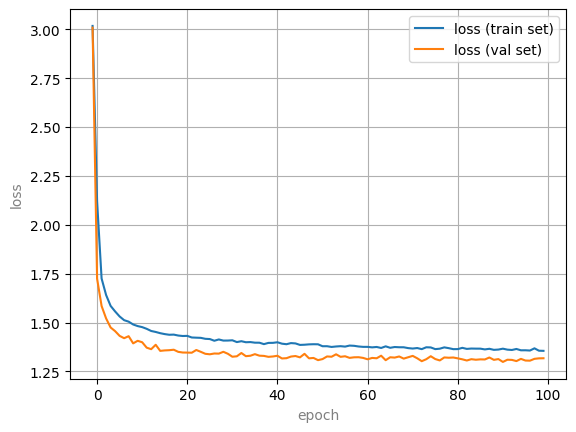

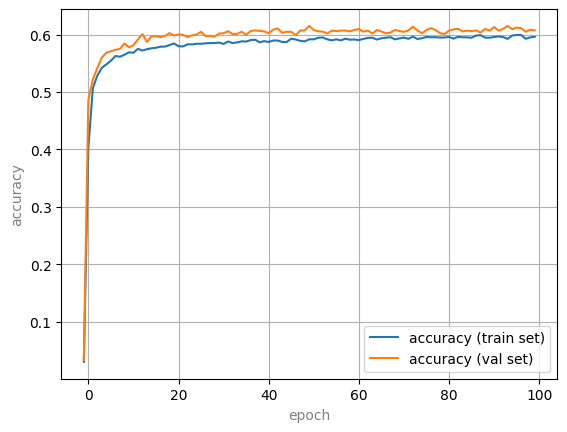

In [21]:
pylab.plot(trace[:,0],trace[:,1],label = 'loss (train set)')
pylab.plot(trace[:,0],trace[:,3],label = 'loss (val set)')
pylab.xlabel("epoch",color = [0.5,0.5,0.5])
pylab.ylabel("loss",color = [0.5,0.5,0.5])
pylab.grid()
pylab.legend()
pylab.show()
pylab.plot(trace[:,0],trace[:,2],label = 'accuracy (train set)')
pylab.plot(trace[:,0],trace[:,4],label = 'accuracy (val set)')
pylab.xlabel("epoch",color = [0.5,0.5,0.5])
pylab.ylabel("accuracy",color = [0.5,0.5,0.5])
pylab.grid()
pylab.legend()
pylab.show()

In [22]:
#torch.save(classifier.model.state_dict(),'models/_sismetanin_bert_bs_4_do_ON_wts_ON_100_epo_adam_lr4e4_')

In [15]:
classifier.model.load_state_dict(torch.load('models/_bs_4_do_ON_wts_ON_100_epo_adadelta'))

<All keys matched successfully>

In [23]:
#torch.save(classifier.model.classifier.state_dict(),'models/_bs_4_do_ON_wts_ON_100_epo_adadelta_head')

In [29]:
classifier.model.classifier.load_state_dict(torch.load('models/_bs_4_do_ON_wts_ON_100_epo_adadelta_head'))

<All keys matched successfully>

In [30]:
predictions = predict_labels(classifier, validloader, scores = True)

100%|██████████| 1662/1662 [00:47<00:00, 34.83it/s]


                   precision    recall  f1-score   support

    offline_crime       0.65      0.20      0.30      1038
     online_crime       0.43      0.84      0.57       208
            drugs       0.77      0.72      0.75       712
         gambling       0.60      0.87      0.71       414
      pornography       0.62      0.38      0.47       376
     prostitution       0.52      0.76      0.62       221
          slavery       0.49      0.73      0.59       200
          suicide       0.68      0.76      0.72       270
        terrorism       0.70      0.72      0.71       216
          weapons       0.85      0.81      0.83       443
     body_shaming       0.58      0.72      0.64       193
   health_shaming       0.61      0.70      0.65       289
         politics       0.50      0.38      0.43       329
           racism       0.34      0.70      0.46       156
         religion       0.87      0.96      0.91       813
sexual_minorities       0.70      0.74      0.72       

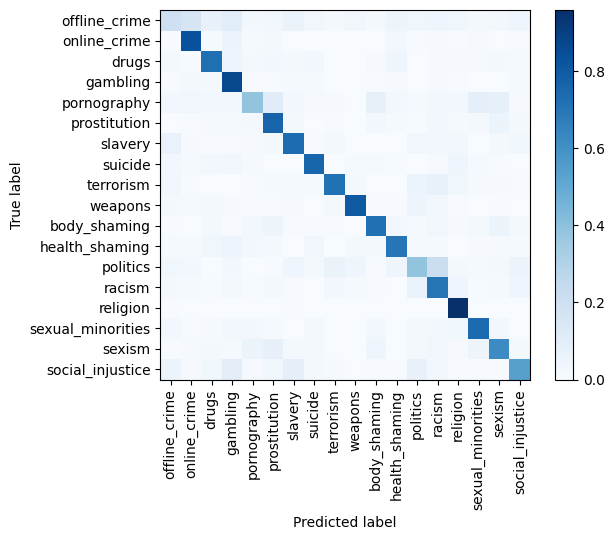

In [31]:
ConfusionMatrixDisplay.from_predictions(torch.flatten(torch.tensor([list(torch.argmax(lbl, dim = 1)) for _, lbl in validloader])),
                                        torch.flatten(torch.argmax(torch.tensor(predictions), dim = 2)), 
                                        display_labels = list(LabtoNum.keys()), include_values = False,
                                        cmap = 'Blues', normalize = 'true', xticks_rotation = 'vertical')

print(classification_report(torch.flatten(torch.tensor([list(torch.argmax(lbl, dim = 1)) for _, lbl in validloader])),
                            torch.flatten(torch.argmax(torch.tensor(predictions), dim = 2)), 
                            target_names = list(LabtoNum.keys())))

In [22]:
from sklearn.metrics import f1_score

In [23]:
sm = torch.nn.Softmax(dim = 0)
#sm = lambda x : x
cutoff = 0.1
num_classes = len(predictions[0][0])

In [24]:
trace = []

In [25]:
for cutoff in tqdm(np.arange(0.01,0.99,0.02)):
    class_slices_pred = [[1 if sm(p)[i] > cutoff else 0 for elm in torch.tensor(predictions) for p in elm] # проход по батчам и слияние всего в один список
        for i in range(num_classes)]  

    class_slices_true =  [[int(l[i]) for _, lbl in validloader for l in lbl] # проход по батчам и слияние всего в один список
        for i in range(num_classes)]  

    trace.append(
                [cutoff, f1_score([[int(a) for a in l] for _, lbl in validloader for l in lbl],
                                   [[1 if v > cutoff else 0 for v in sm(l)] for elm in torch.tensor(predictions) for l in elm], average = 'macro')] +\
                [f1_score(class_slices_true[num], class_slices_pred[num]) for num in range(num_classes)])
trace = np.array(trace)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [04:54<00:00,  6.02s/it]


[]

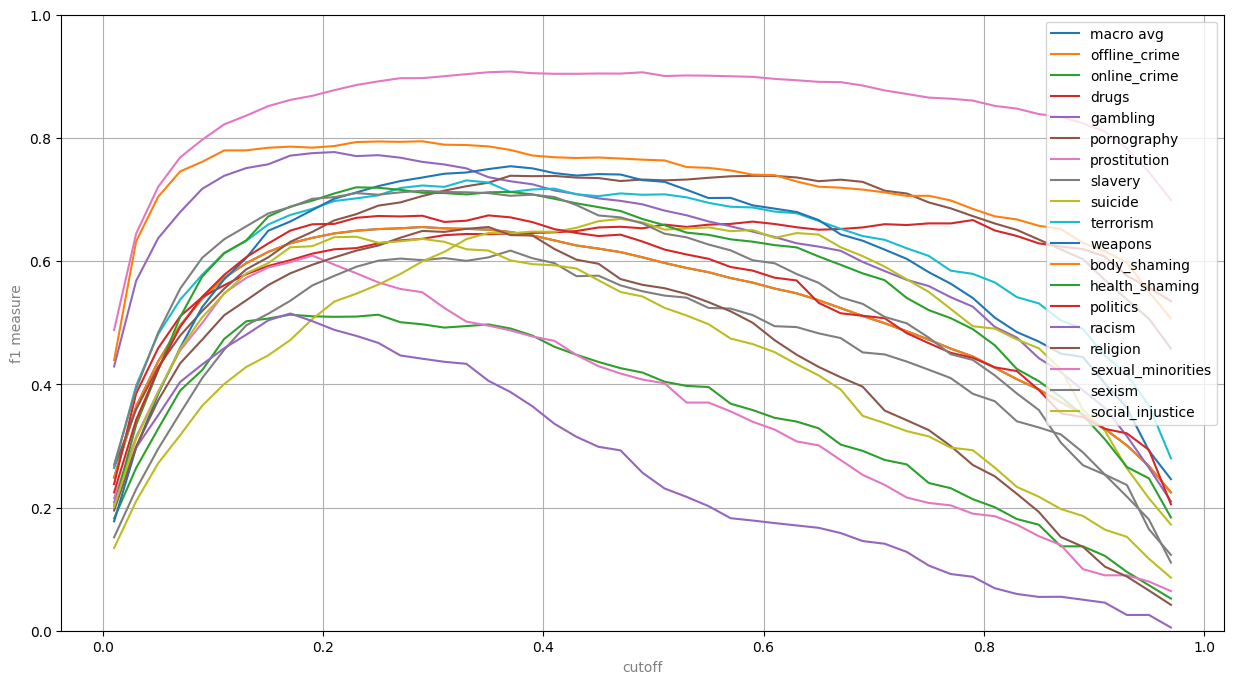

In [29]:
f, axes = plt.subplots(figsize=(15, 8))
pylab.plot(trace[:,0],trace[:,1],label = 'macro avg')
for i in range(num_classes):
    pylab.plot(trace[:,0],trace[:,i + 1],label = f'{NumToLab[i]}')
pylab.xlabel("cutoff",color = [0.5,0.5,0.5])
pylab.ylabel("f1 measure",color = [0.5,0.5,0.5])
pylab.ylim([0,1])
pylab.grid()
pylab.legend()
pylab.plot()

In [30]:
cutoff_optimal = []
for i in range(num_classes + 1):
    cutoff_optimal.append(trace[:,0][np.argmax(trace[:,i + 1])])
cutoff_optimal_classes = cutoff_optimal[1:]

In [31]:
cutoff_optimal

[0.29,
 0.16999999999999998,
 0.7899999999999999,
 0.20999999999999996,
 0.36999999999999994,
 0.18999999999999997,
 0.36999999999999994,
 0.4699999999999999,
 0.32999999999999996,
 0.36999999999999994,
 0.29,
 0.22999999999999998,
 0.35,
 0.16999999999999998,
 0.35,
 0.36999999999999994,
 0.29,
 0.22999999999999998,
 0.12999999999999998]

In [48]:
for i in range(num_classes):
    print(f"{NumToLab[i] + ''.join([' ' for _ in range(15 - len(NumToLab[i]))])} \t-\t {cutoff_optimal_classes[i]:.2f}")

offline_crime   	-	 0.21
online_crime    	-	 0.83
drugs           	-	 0.23
gambling        	-	 0.51
pornography     	-	 0.15
prostitution    	-	 0.41
slavery         	-	 0.39
suicide         	-	 0.33
terrorism       	-	 0.31
weapons         	-	 0.51
body_shaming    	-	 0.35
health_shaming  	-	 0.55
politics        	-	 0.15
racism          	-	 0.19
religion        	-	 0.23
sexual_minorities 	-	 0.47
sexism          	-	 0.23
social_injustice 	-	 0.23


In [34]:
cutoff = 0.21

# mltcls_matr = multilabel_confusion_matrix([[int(a) for a in l] for _, lbl in validloader for l in lbl],
#                             [[1 if v > cutoff else 0 for v in sm(l)] for elm in torch.tensor(predictions) for l in elm])

mltcls_matr = multilabel_confusion_matrix([[int(a) for a in l] for _, lbl in validloader for l in lbl],
                            [[1 if cprb > cutoff_optimal_classes[cnum] else 0 for cnum, cprb in enumerate(sm(l))] for elm in torch.tensor(predictions) for l in elm])

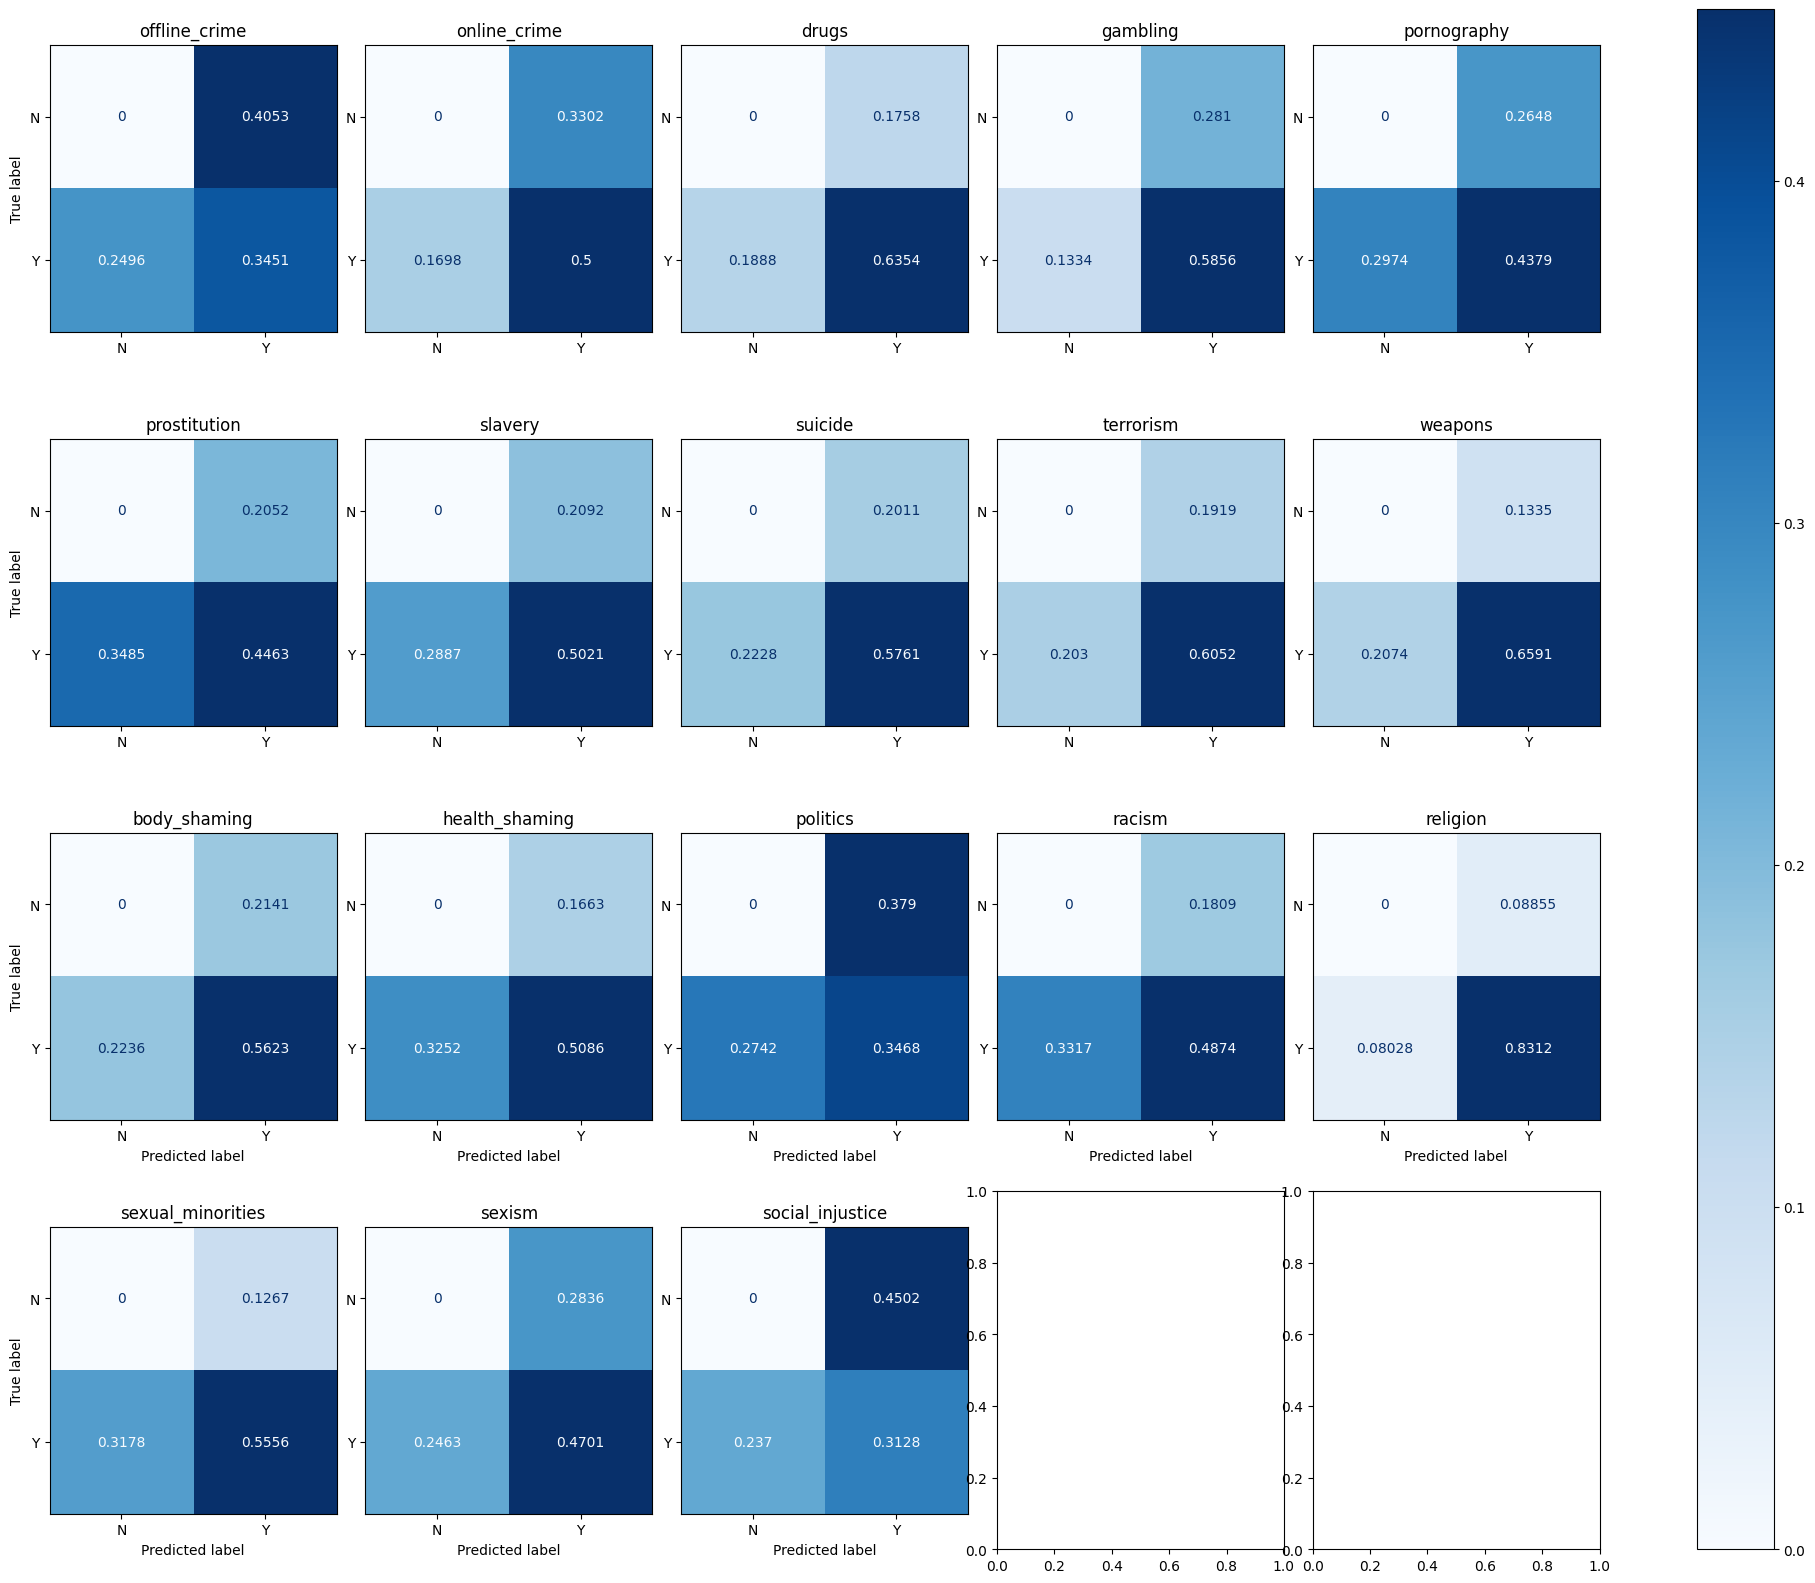

In [35]:
f, axes = plt.subplots(4, len(list(LabtoNum.keys())) // 4 + 1, figsize=(25, 20))
axes = axes.ravel()

for i in range(len(list(LabtoNum.keys()))):
    disp_matr = np.matrix([
        [mltcls_matr[i][0,0] * 0 / mltcls_matr[i][0,0], 
         mltcls_matr[i][0,1] / (mltcls_matr[i][1,1] + mltcls_matr[i][0,1] + mltcls_matr[i][1,0])],
        [mltcls_matr[i][1,0] / (mltcls_matr[i][1,1] + mltcls_matr[i][1,0] + mltcls_matr[i][0,1]), 
         mltcls_matr[i][1,1] /  (mltcls_matr[i][1,1] +  mltcls_matr[i][0,1] + mltcls_matr[i][1,0])]
    ])
    disp = ConfusionMatrixDisplay(disp_matr,
                                  display_labels=['N', 'Y'])
    
    disp.plot(ax=axes[i], cmap = 'Blues', values_format='.4g')
    disp.ax_.set_title(list(LabtoNum.keys())[i])
    
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
    
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
mltcls_matr = multilabel_confusion_matrix([[int(a) for a in l] for _, lbl in validloader for l in lbl],
                            [[1 if v > cutoff else 0 for v in sm(l)] for elm in torch.tensor(predictions) for l in elm])

In [40]:
cutoff = 0.6

In [41]:
print(classification_report([[int(a) for a in l] for _, lbl in validloader for l in lbl],
                            [[1 if v > cutoff else 0 for v in sm(l)] for elm in torch.tensor(predictions) for l in elm], 
                            target_names = list(LabtoNum.keys())))

                   precision    recall  f1-score   support

    offline_crime       0.76      0.23      0.36       336
     online_crime       0.57      0.80      0.66       217
            drugs       0.93      0.49      0.64       764
         gambling       0.81      0.68      0.74       458
      pornography       0.88      0.21      0.34       361
     prostitution       0.78      0.37      0.51       244
          slavery       0.77      0.57      0.65       189
          suicide       0.86      0.56      0.68       294
        terrorism       0.88      0.56      0.69       219
          weapons       0.89      0.63      0.74       422
     body_shaming       0.90      0.48      0.63       246
   health_shaming       0.85      0.44      0.58       341
         politics       0.76      0.10      0.17       385
           racism       0.89      0.33      0.49       326
         religion       0.94      0.86      0.90       772
sexual_minorities       0.96      0.43      0.60       

C:\Users\max\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\max\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report([[int(a) for a in l] for _, lbl in validloader for l in lbl],
                            [[1 if cprb > cutoff_optimal_classes[cnum] else 0 for cnum, cprb in enumerate(sm(l))] for elm in torch.tensor(predictions) for l in elm], 
                            target_names = list(LabtoNum.keys())))

                   precision    recall  f1-score   support

    offline_crime       0.53      0.50      0.52       340
     online_crime       0.58      0.66      0.62       205
            drugs       0.75      0.69      0.72       740
         gambling       0.75      0.70      0.72       404
      pornography       0.41      0.61      0.49       370
     prostitution       0.85      0.61      0.71       228
          slavery       0.69      0.55      0.61       201
          suicide       0.78      0.79      0.78       311
        terrorism       0.76      0.76      0.76       285
          weapons       0.85      0.74      0.79       420
     body_shaming       0.69      0.55      0.61       240
   health_shaming       0.78      0.62      0.69       321
         politics       0.46      0.55      0.50       402
           racism       0.62      0.62      0.62       303
         religion       0.94      0.87      0.90       827
sexual_minorities       0.88      0.63      0.73       

C:\Users\max\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\max\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


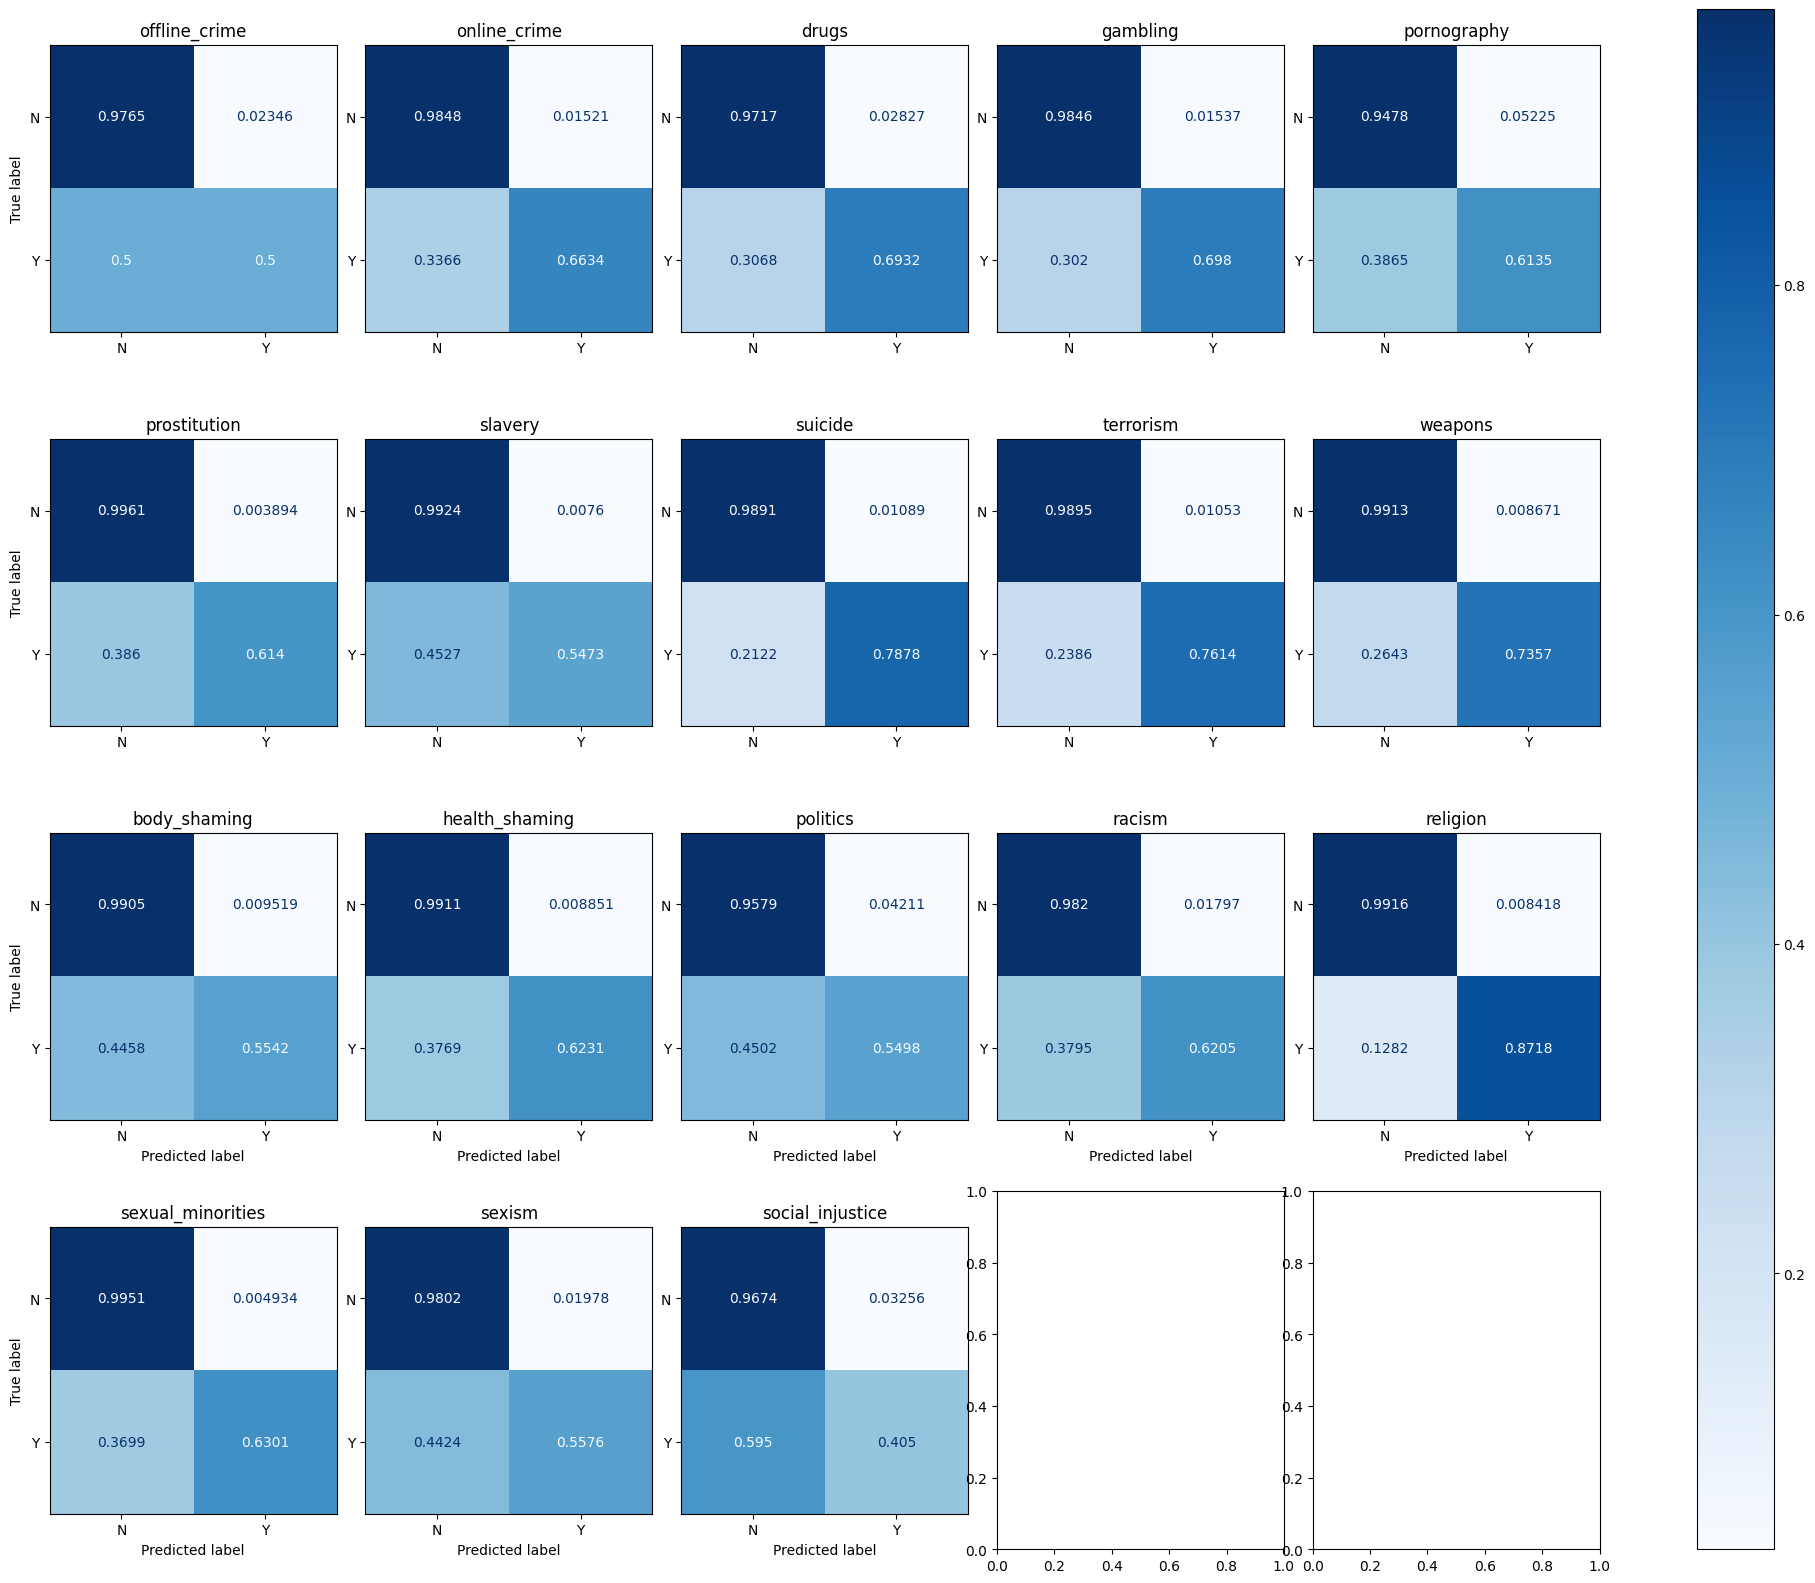

In [ ]:
f, axes = plt.subplots(4, len(list(LabtoNum.keys())) // 4 + 1, figsize=(25, 20))
axes = axes.ravel()

for i in range(len(list(LabtoNum.keys()))):

    disp = ConfusionMatrixDisplay(mltcls_matr[i] / np.matrix(np.sum(mltcls_matr[i],axis = 1)).transpose(),
                                  display_labels=['N', 'Y'])
    
    disp.plot(ax=axes[i], cmap = 'Blues', values_format='.4g')
    disp.ax_.set_title(list(LabtoNum.keys())[i])
    
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
    
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

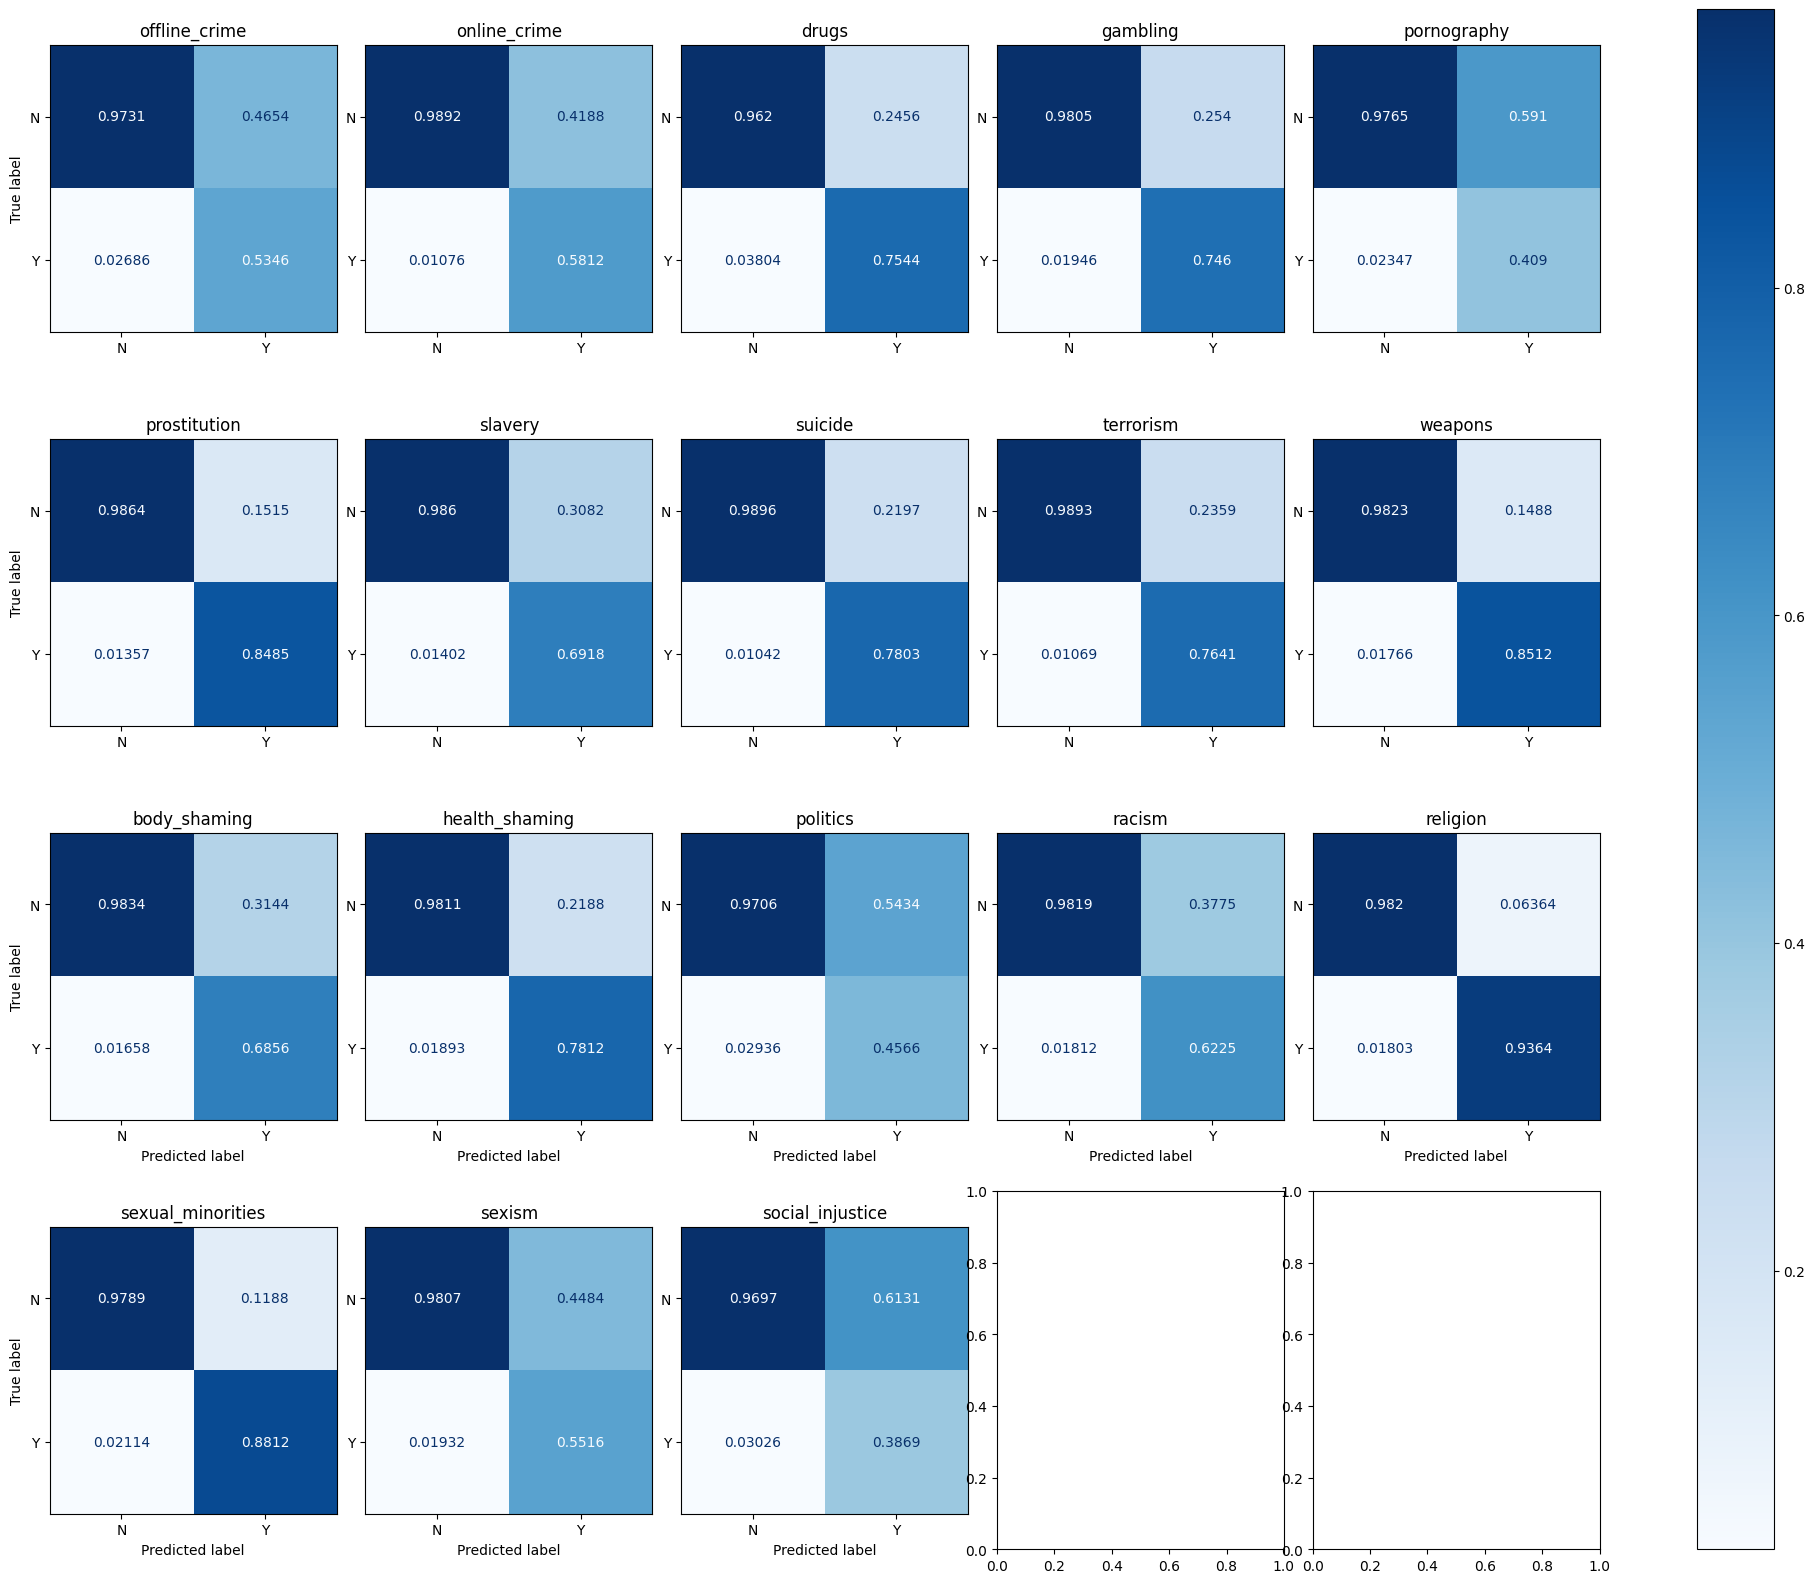

In [ ]:
f, axes = plt.subplots(4, len(list(LabtoNum.keys())) // 4 + 1, figsize=(25, 20))
axes = axes.ravel()

for i in range(len(list(LabtoNum.keys()))):

    disp = ConfusionMatrixDisplay(mltcls_matr[i] / np.matrix(np.sum(mltcls_matr[i],axis = 0)),
                                  display_labels=['N', 'Y'])
    
    disp.plot(ax=axes[i], cmap = 'Blues', values_format='.4g')
    disp.ax_.set_title(list(LabtoNum.keys())[i])
    
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
    
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()